In [23]:
################################
########### IMPORTS ############
################################

In [1]:
from pycbc import distributions
from pycbc.waveform import get_td_waveform, td_approximants
from pycbc.detector import Detector
import matplotlib.pyplot as plt
import numpy as np
import gwpy
import pylab
from tqdm.notebook import tqdm
from gwpy.timeseries import TimeSeries
import pandas as pd
import os
import csv
import pycbc.noise
import pycbc.psd
from pycbc.filter import matched_filter
import random

/Users/adamvanzant/.pyenv/versions/gw_env_39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
##########################################
########### CONFIG PARAMETERS ############
##########################################

In [ ]:
DATA_PATH = " Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/models/debugging/Missing Data Imputation/Test 1/data/"
NO_OF_TRAINING_SAMPLES = 1000
NOISE_DURATION = 10             # in min
TOTAL_SIGNAL_DURATION = 8       # in min
EACH_SIGNAL_DURATION = 5        # in sec
SIGNAL_SPACING = 2              # in sec
MISSING_DURATION = 0.2          # in sec
COSINE_FREQ_LBOUND = 100
COSINE_FREQ_UBOUND = 4096
SIGNAL_AMPLITUDE_SUPPRESSION = 0.2 # 0.2

In [4]:
##################################################
########### COLOURED NOISE GENERATION ############
##################################################

In [5]:
def generateColoredNoise():
    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    # Generate 4 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(NOISE_DURATION*60 / delta_t)
    noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd)

    noise *= 1e21
    noise = TimeSeries.from_pycbc(noise)

    return noise

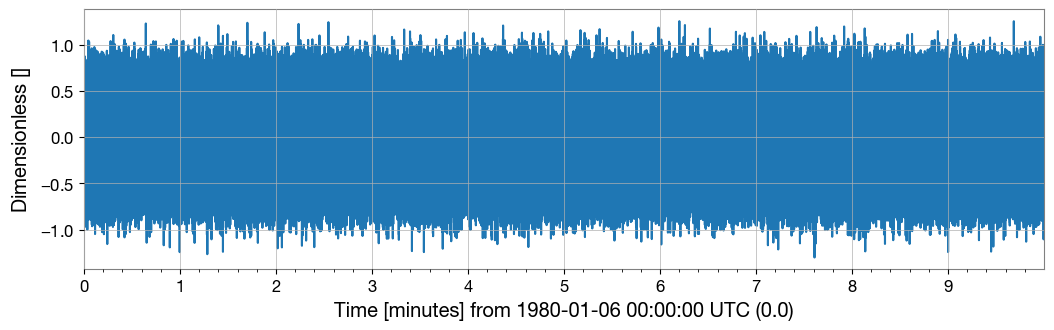

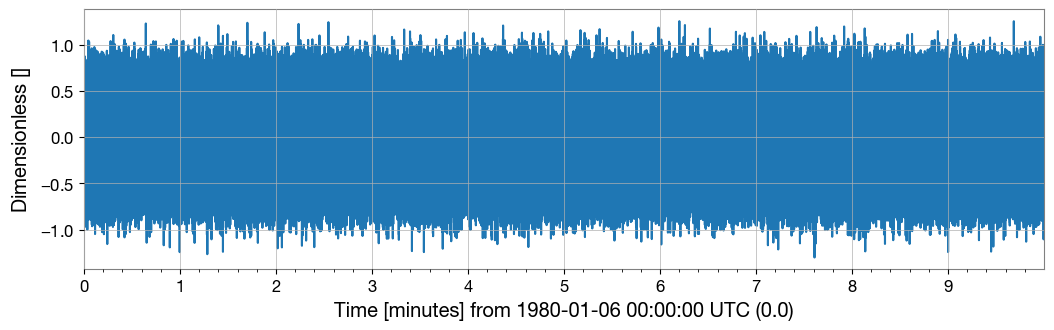

In [6]:
noise = generateColoredNoise()
noise.plot()

In [7]:
###############################################
########### COSINE WAVE GENERATION ############
###############################################

In [8]:
# Trash Code

# time = TimeSeries(np.arange(0, 100), sample_rate=4096)
# time = time.to_value()
# wave = np.cos(time)
# plt.plot(time, wave)
# plt.show()

In [9]:
# This function generates cosine wave 
# of given duration, frequency with 
# randomly sampled amplitude and start time
def generateRandomCosine(duration, frequency):
    x_right_bound = int(60*(1/frequency)*4096) + 1 # sets the right hand bound for x values such that 60 sec of signal data is generated
    x = np.arange(0, x_right_bound, (1/frequency))
    
    random_amp_scale = np.random.random() if np.random.random() else 1
    
    wave = SIGNAL_AMPLITUDE_SUPPRESSION*random_amp_scale*np.cos(x)
    wave = TimeSeries(wave, sample_rate=4096).to_pycbc()

    random_start = int(np.random.random()*(60 - duration))
    
    wave = TimeSeries.from_pycbc(wave.time_slice(random_start, random_start+duration))
    wave.t0 = 0

    return wave

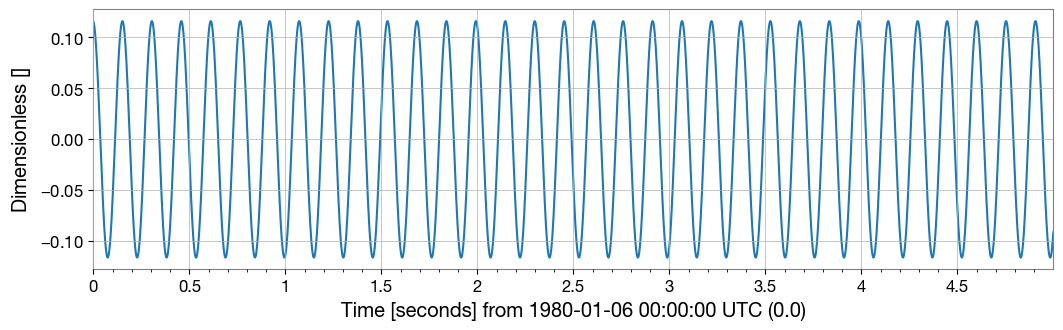

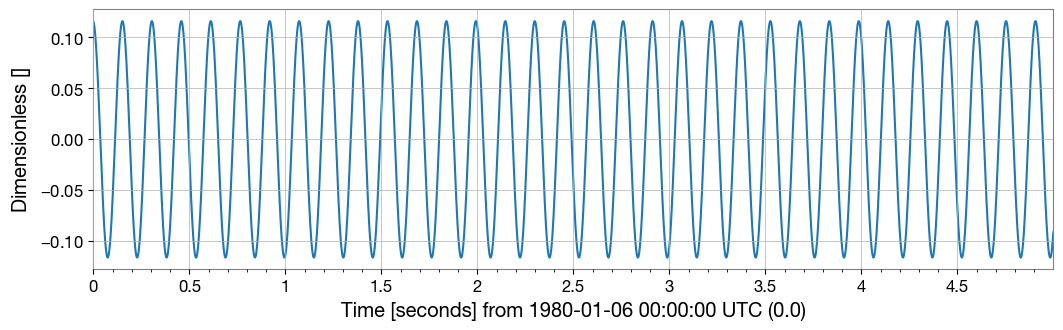

In [10]:
cosine = generateRandomCosine(5, 100)
cosine.plot()

In [11]:
# This function generates array of
# cosine wave using generateRandomCosine
# with random frequency
def generateSignals():
    signals = []
    n_signals = int(((NOISE_DURATION - TOTAL_SIGNAL_DURATION)*60)/SIGNAL_SPACING) + 1

    for i in range(n_signals):
        r = np.random.random() if np.random.random() else 1
        random_freq = int(r*COSINE_FREQ_UBOUND) + COSINE_FREQ_LBOUND
        signals.append(generateRandomCosine(EACH_SIGNAL_DURATION, random_freq))

    return signals

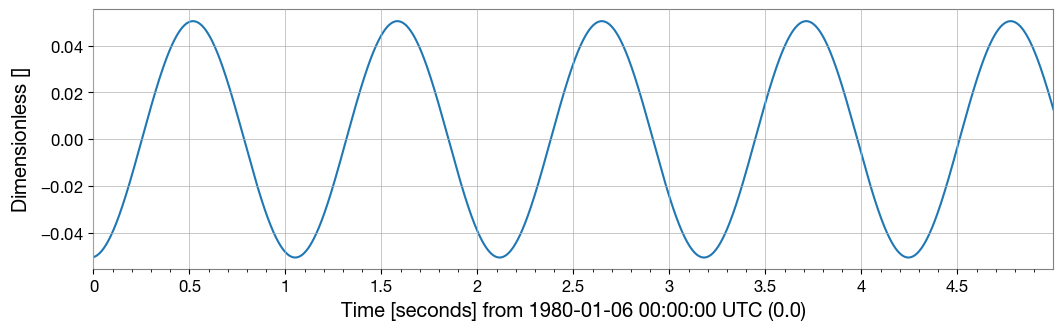

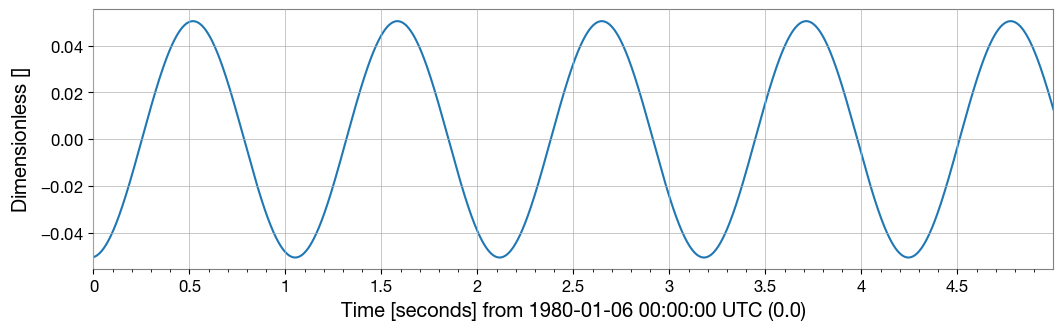

In [12]:
s = generateSignals()
s[27].plot()

In [13]:
###############################################
########### SAMPLE DATA GENERATION ############
###############################################

In [14]:
# This function generates
# one data sample with 
# every signal injected at
# random start time in noise

def generateDataSample():
     data = generateColoredNoise()
     signals = generateSignals()

     for signal in signals:
         random_start = int(np.random.random()*(TOTAL_SIGNAL_DURATION*60 - EACH_SIGNAL_DURATION - 2))

         signal.t0 = random_start
         data = data.inject(signal)

     return data

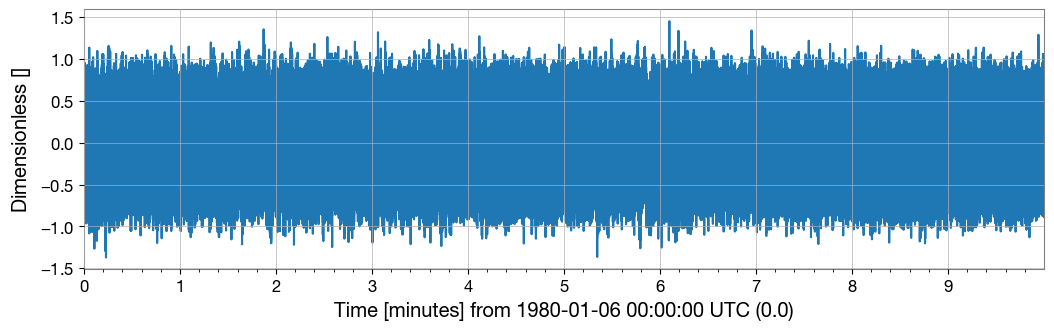

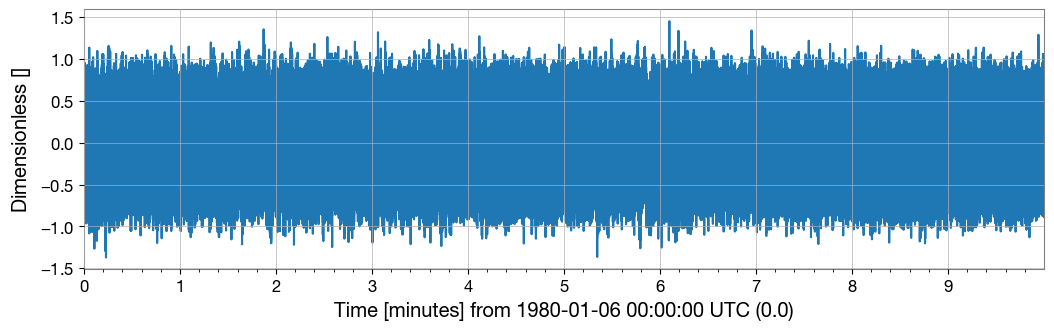

In [15]:
data = generateDataSample()
data.plot()

In [16]:
# This function generates
# one data sample with 
# every signal injected with
# equal seperation till the end
def generateDataSample():
    data = generateColoredNoise()
    signals = generateSignals()
    
    start = 0
    seperation = EACH_SIGNAL_DURATION + SIGNAL_SPACING

    for signal in signals:
        signal.t0 = start
        start += seperation

        data = data.inject(signal)

    return data

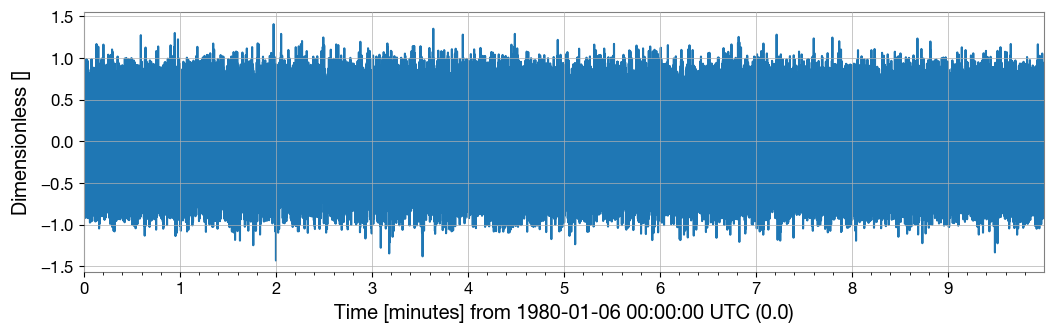

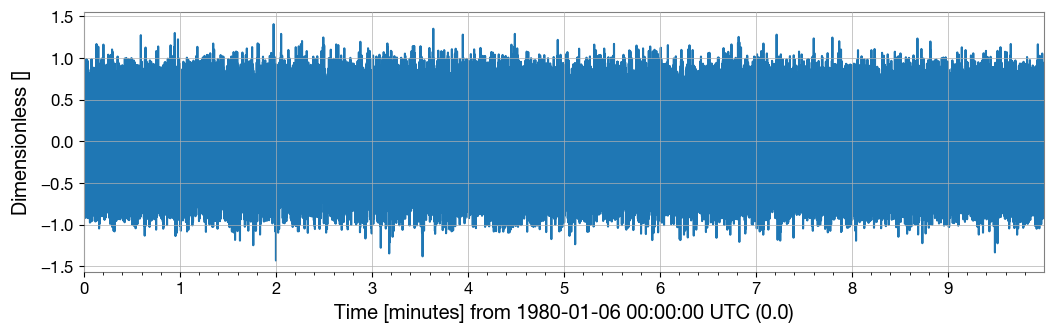

In [17]:
data = generateDataSample()
data.plot()

In [18]:
#####################################################
########### MISSING DATA MASK GENERATION ############
#####################################################

In [19]:
print(random.sample([0, 1], counts=[int(MISSING_DURATION*60*4096), int((NOISE_DURATION - MISSING_DURATION)*60*4096)], k=int(NOISE_DURATION*60*4096)))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

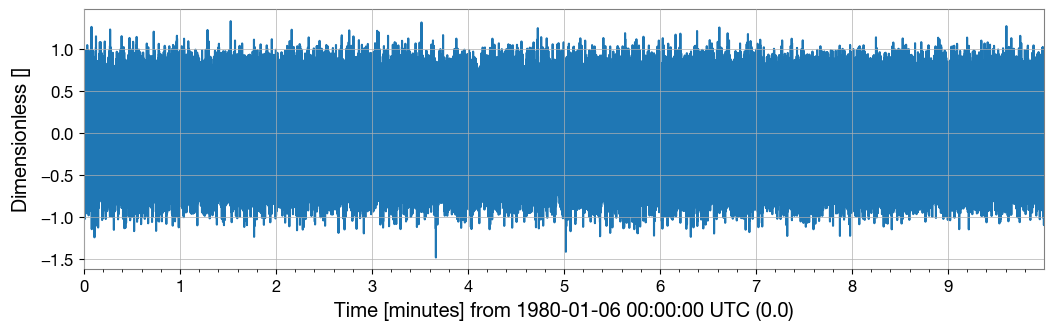

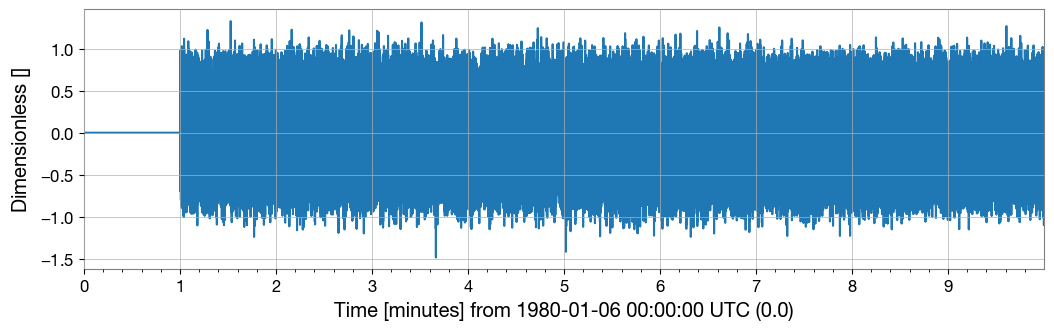

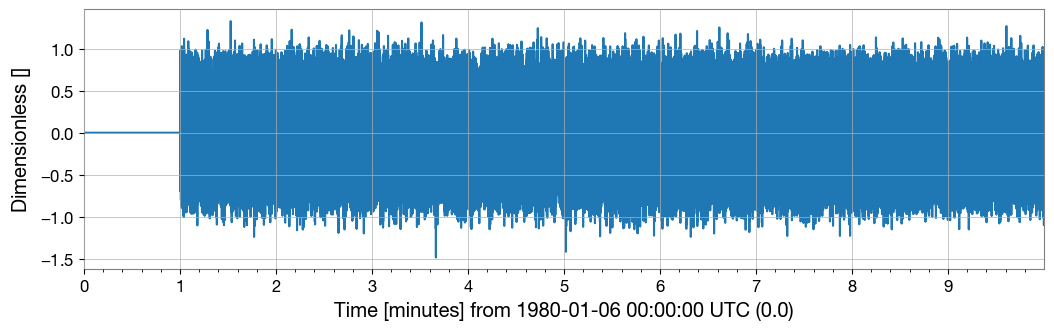

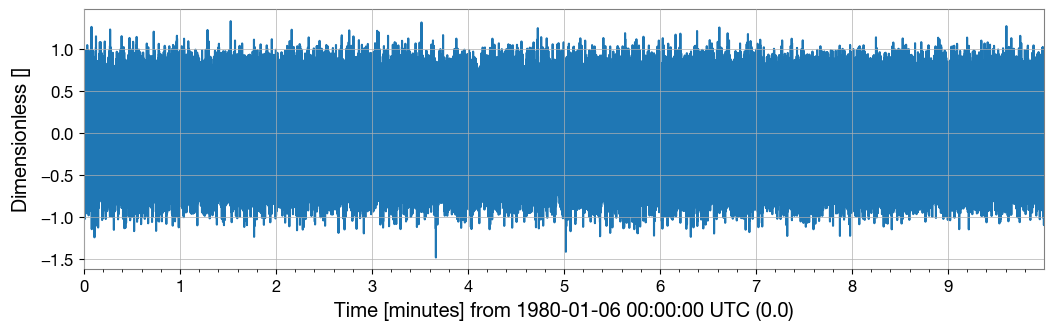

In [20]:
data = generateDataSample()
data1 = data.copy()

l = [1 for i in range(len(data1.value))]
temp = data1.value

for i in range(0, 4096*60):
    l[i] = 0

temp *= l  # This modifies temp, but new_data needs to be defined properly

# ✅ Correcting the definition of new_data
new_data = TimeSeries(temp, sample_rate=4096)  # Assign temp to new_data

# ✅ Now this will work without NameError
new_data.plot()
data1.plot()
data.plot()

In [21]:
##############################################
########### FINAL DATA GENERATION ############
##############################################

In [ ]:
import os
import csv
from tqdm import tqdm
import numpy as np

# Define your data path correctly
DATA_PATH = " Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/models/debugging/Missing Data Imputation/Test 1/data/"

# Ensure the directory exists
os.makedirs(DATA_PATH, exist_ok=True)

# Open CSV files in the specified directory
f = open(os.path.join(DATA_PATH, "data.csv"), 'w')
g = open(os.path.join(DATA_PATH, "mask.csv"), 'w')

cw1 = csv.writer(f)
cw2 = csv.writer(g)

# Generate data
data = generateDataSample()  # Ensure this function is defined
cw1.writerow([MISSING_DURATION])  # Ensure MISSING_DURATION is defined
cw1.writerow(data.value)  # Ensure data.value is iterable and correctly formatted
f.close()

# Loop to generate training samples
for i in tqdm(range(NO_OF_TRAINING_SAMPLES)):  # Ensure NO_OF_TRAINING_SAMPLES is defined
    random_mask_start = int(np.random.random() * 4096 * (NOISE_DURATION * 60 - MISSING_DURATION - 1))
    cw2.writerow([random_mask_start])  # Ensure NOISE_DURATION & MISSING_DURATION are defined

g.close()

100%|██████████| 1000/1000 [00:00<00:00, 885060.98it/s]
